Author: **SrisaicharanVelisetti**

In [ ]:
# import the necessary packages
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from statistics import mean
import torchvision.models as models

# Backpropagation in Neural Networks

#### Overview
Artificial Neural Networks are computational learning systems that uses a network of functions to understand and translate a data input of one form into a desired output, usually in another form. The concept of the artificial neural network was inspired by human biology and the way neurons of the human brain function together to understand inputs from human senses.

A simple neural network consists of Input Layer, Hidden Layer and Output Layer.
To train these the network, we will use Backpropagation algorithm.  Backpropagation is the cornerstone of modern neural networks. To understand the algorithm in details, here is a mathematical description in the Chapter 2 of *How the backpropagation algorithm works from Neural Networks and Deep Learning* (http://neuralnetworksanddeeplearning.com/chap2.html).

In this part, you are required to implement the following architecture and write training code of a neural network from scratch using the numpy library alone. 

Architecture Definition :

*   An Input Layer with the following 2-dimensions:
  *  0: Batch Size
  *  1: 784 = 28*28 pixels
* A hidden layer with 500 units
* A second hidden layer with 50 units
* An output layer with 10 units

There are five major steps to the implementation:

1. Define neural network: initialize_network()

2. Forward Propagation: pre_activation(), sigmoid_activation(), forward_propagation()

3. Backpropagation: backward_propagate_error()

4. Loss function and updation of weights (SGD): update_weights()

5. Training: train()


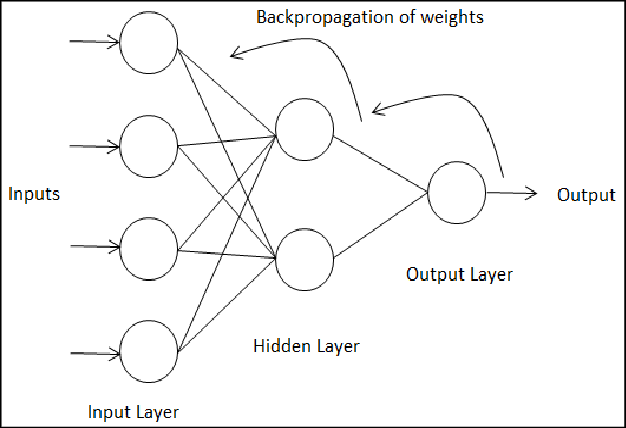



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 11SpETIc56PReKuaUKEwWDvdkiynyyGFA
!unzip "/content/MNISTArchive.zip" -d "/content/"
!gzip -d "/content/t10k-labels-idx1-ubyte.gz"
!gzip -d "/content/t10k-images-idx3-ubyte.gz" 
!gzip -d "/content/train-labels-idx1-ubyte.gz"
!gzip -d "/content/train-images-idx3-ubyte.gz"

## Helper Functions:

### Code 

In [ ]:
def read_mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

In [ ]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	
	hidden_layer = None
	hidden_layer = [{'weights' : [random() for i in range(n_inputs+1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
 
	output_layer = None
	output_layer = [{'weights' : [random() for i in range(n_hidden+1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

In [ ]:
# Calculate neuron activation for an input
def pre_activation(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

def sigmoid_activation(activation):
	out_sigmoid=None
	out_sigmoid = 1.0 / (1.0 + np.exp(-activation))
	return out_sigmoid
 
# Calculate the derivative of a neuron output
def sigmoid_derivative(output):
	out_sigmoid_deriv = None
	out_sigmoid_deriv = (output * (1.0 - output))
	return out_sigmoid_deriv

In [ ]:
# Forward Propagation:
def forward_propagation(network, row):
	inputs = row
	for layer in network:

		new_inputs = []
		## write you code here.
		## for each hidden neuron this 'layer', compute \
		## pre_activation, sigmoid_activation and save then output in 'new_inputs.'
		for neuron in layer:
			activation = pre_activation(neuron['weights'],inputs)
			neuron['out_sigmoid'] = sigmoid_activation(activation)
			new_inputs.append(neuron['out_sigmoid'])
	 	
		inputs = new_inputs
	return inputs

# Backpropagation:
def backward_propagate_error(network, ground_truth):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			## compute error for all the hidden layer and append it to errors to keep track.
			for j in range(len(layer)):
				error = 0
				for neuron in network[i+1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			## compute error for the output layer using ground_truth and append it to errors to keep track.
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(neuron['out_sigmoid'] - ground_truth[j])			
	 
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * sigmoid_derivative(neuron['out_sigmoid'])  
   
# Stochastic GD for weight updation:
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			## pass activation i.e. neuron['output'] from previous layer as input to current layer 'i'
			inputs = [neuron['out_sigmoid'] for neuron in network[i-1]]
				
	 
		for neuron in network[i]:						
			for j in range(len(inputs)):
				## update the weights between each input and each neuron.
				neuron['weights'][j] -= neuron['delta'] * inputs[j] * l_rate

			## update the bias vector
			neuron['weights'][-1] -= neuron['delta'] * l_rate
	 
# Train a network for a fixed number of epochs
def train(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		sum_error = 0
		for row in train:
			outputs = forward_propagation(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)
		print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))      
	

In [ ]:
# 1. Test your code for backprop algorithm on this sample dataset.
seed(1)
sample_dataset = [[2.7810836,2.550537003,0],
	[1.465489372,2.362125076,0],
	[3.396561688,4.400293529,0],
	[1.38807019,1.850220317,0],
	[3.06407232,3.005305973,0],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]]

n_inputs = len(sample_dataset[0]) - 1
n_outputs = len(set([sample[-1] for sample in sample_dataset]))
network = initialize_network(n_inputs, 2, n_outputs)
train(network, sample_dataset, l_rate=0.5, n_epoch=50, n_outputs=n_outputs)
for layer in network:
	print(layer)

>epoch=0, lrate=0.500, error=6.350
>epoch=1, lrate=0.500, error=5.531
>epoch=2, lrate=0.500, error=5.221
>epoch=3, lrate=0.500, error=4.951
>epoch=4, lrate=0.500, error=4.519
>epoch=5, lrate=0.500, error=4.173
>epoch=6, lrate=0.500, error=3.835
>epoch=7, lrate=0.500, error=3.506
>epoch=8, lrate=0.500, error=3.192
>epoch=9, lrate=0.500, error=2.898
>epoch=10, lrate=0.500, error=2.626
>epoch=11, lrate=0.500, error=2.377
>epoch=12, lrate=0.500, error=2.153
>epoch=13, lrate=0.500, error=1.953
>epoch=14, lrate=0.500, error=1.774
>epoch=15, lrate=0.500, error=1.614
>epoch=16, lrate=0.500, error=1.472
>epoch=17, lrate=0.500, error=1.346
>epoch=18, lrate=0.500, error=1.233
>epoch=19, lrate=0.500, error=1.132
>epoch=20, lrate=0.500, error=1.042
>epoch=21, lrate=0.500, error=0.961
>epoch=22, lrate=0.500, error=0.887
>epoch=23, lrate=0.500, error=0.821
>epoch=24, lrate=0.500, error=0.761
>epoch=25, lrate=0.500, error=0.707
>epoch=26, lrate=0.500, error=0.658
>epoch=27, lrate=0.500, error=0.613
>e

In [ ]:
# 2. Read MNIST data and test above algorithm on it.

# Read MNIST data
train_images, train_labels, test_images, test_labels = read_mnist(path='/content/')
print(train_images.shape, train_labels.shape)
sd=np.hstack((train_images,train_labels))
# Run Backpropagation.

n_inputs = len(sample_dataset[0]) - 1
n_outputs = len(set([sample[-1] for sample in sample_dataset]))
network = initialize_network(n_inputs, 10, n_outputs)

train(network, sd, l_rate=0.5, n_epoch=20, n_outputs=10)
for layer in network:
	print(layer)

### Tasks

1. Report  train error w.r.t epoch, train and test accuracy numbers on MNIST dataset at the end of training.
2. Experimenting with different number of hidden layers, training epochs and report the ablation study.

https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/

https://github.com/profthyagu/Python-ANN-Backpropagation/blob/master/4.ANN_BackPropogation.ipynb

https://gist.github.com/nickstenning/887946

https://github.com/dcavar/python-tutorial-notebooks/blob/master/notebooks/Backpropagation.ipynb

https://github.com/jariasf/CS231n/blob/master/assignment2/cs231n/layers.py

# Training an Image Classifier

##Overview
CIFAR10 dataset will be used to train an image classifier.

![](https://miro.medium.com/max/578/1*BCsHErqOJxmKDLQXYJR_ow.png)



##Data
Using `torchvision`, it’s extremely easy to load `CIFAR10`.

In [ ]:
## The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


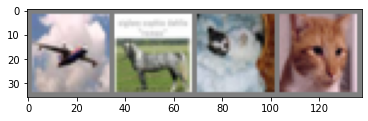

plane horse dog   cat  


In [ ]:
## Let us show some of the training images, for fun.

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

###Define a Convolutional Neural Network 

Creating a neural network that take 3-channel images. Network archtecture Conv2d --> ReLU --> MaxPool2d --> Conv2d --> ReLU --> MaxPool2d --> Flatten --> Linear --> ReLU --> Linear --> ReLU --> Linear

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,16,3,padding=1)
        self.dp= nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(16 * 8 * 8,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,16)
        self.fc5 = nn.Linear(16,10)

        ## TODO: Add layers to your neural net.

    def forward(self, x):
        ## TODO: run forward pass as mentioned above.
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x=  self.dp(x)
        x = x.view(-1,16 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


net = Net()

###Define a Loss function and optimizer 

Let’s use a Classification Cross-Entropy loss and SGD with momentum. (Feel free to experiment with other loss functions and optimizers to observe differences)

In [ ]:
criterion = nn.CrossEntropyLoss() ## TODO: Add loss function
optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9) ## TODO: Add optimizer

###Training the network  

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
epochs = 10 ## TODO: define number of epochs to train
train_losses = []
train_accuracy = []
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct_values = 0.0
    total = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        correct_values += (predictions == labels).float().sum()
        running_loss += loss.item()
        if i % 2000 == 1999:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    train_accuracy.append((100 * correct_values) / total)
    train_losses.append(running_loss/(i+1))

print('Finished Training')


PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.305
[1,  4000] loss: 2.301
[1,  6000] loss: 2.175
[1,  8000] loss: 1.938
[1, 10000] loss: 1.758
[1, 12000] loss: 1.659
[2,  2000] loss: 1.537
[2,  4000] loss: 1.482
[2,  6000] loss: 1.426
[2,  8000] loss: 1.382
[2, 10000] loss: 1.335
[2, 12000] loss: 1.301
[3,  2000] loss: 1.249
[3,  4000] loss: 1.239
[3,  6000] loss: 1.220
[3,  8000] loss: 1.176
[3, 10000] loss: 1.158
[3, 12000] loss: 1.147
[4,  2000] loss: 1.091
[4,  4000] loss: 1.088
[4,  6000] loss: 1.068
[4,  8000] loss: 1.067
[4, 10000] loss: 1.044
[4, 12000] loss: 1.065
[5,  2000] loss: 0.984
[5,  4000] loss: 0.971
[5,  6000] loss: 1.000
[5,  8000] loss: 0.971
[5, 10000] loss: 0.987
[5, 12000] loss: 1.000
[6,  2000] loss: 0.908
[6,  4000] loss: 0.924
[6,  6000] loss: 0.896
[6,  8000] loss: 0.926
[6, 10000] loss: 0.919
[6, 12000] loss: 0.917
[7,  2000] loss: 0.824
[7,  4000] loss: 0.866
[7,  6000] loss: 0.839
[7,  8000] loss: 0.840
[7, 10000] loss: 0.881
[7, 12000] loss: 0.885
[8,  2000] loss: 0.783
[8,  4000] 

###Testing the network on the test data
We have trained the network over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.


In [ ]:
from sklearn.metrics import confusion_matrix

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0.0
total = 0.0

y_true = []
y_pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_true.extend(labels.numpy())
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        y_pred.extend(predictions.cpu().numpy())
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
    cf_matrix = confusion_matrix(y_true, y_pred)

print(f'Test Accuracy of the network on the 10000 test images: {100 * correct / total} %')
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Test Accuracy of the network on the 10000 test images: 67.63 %
Accuracy for class: plane is 70.4 %
Accuracy for class: car   is 73.6 %
Accuracy for class: bird  is 44.7 %
Accuracy for class: cat   is 57.8 %
Accuracy for class: deer  is 68.5 %
Accuracy for class: dog   is 58.0 %
Accuracy for class: frog  is 76.4 %
Accuracy for class: horse is 70.5 %
Accuracy for class: ship  is 73.6 %
Accuracy for class: truck is 82.8 %


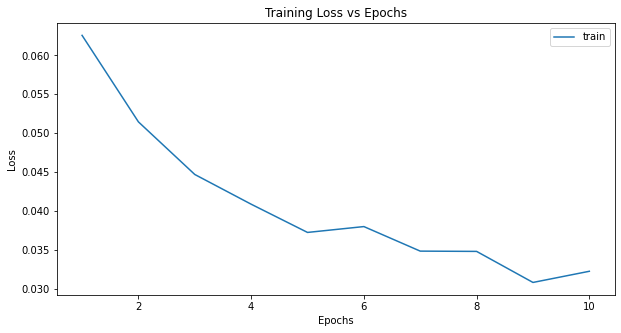

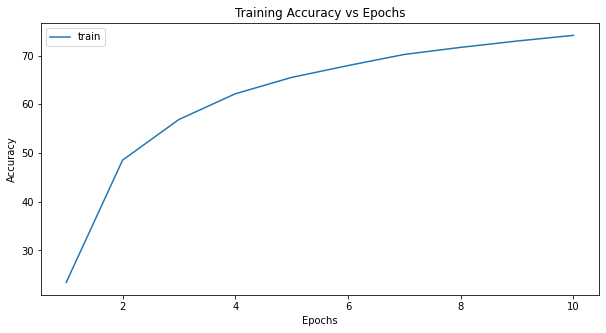

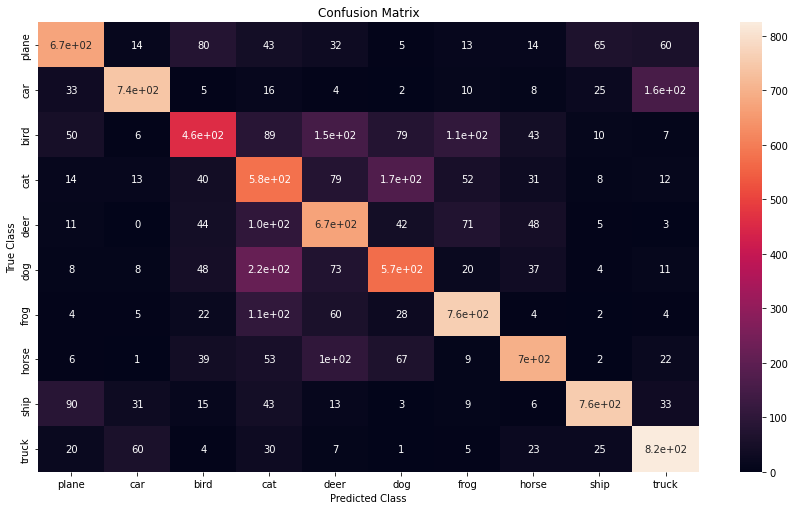

In [ ]:
import seaborn as sn
import pandas as pd
plt.figure(figsize=(10,5))
plt.title("Training Loss vs Epochs")
plt.plot(np.arange(1,11),train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(10,5))
plt.title("Training Accuracy vs Epochs")
plt.plot(np.arange(1,11),train_accuracy,label="train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()